In [18]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics import Accuracy, Precision, Recall, F1Score
import pandas as pd
from torch_trainer import *

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Для CPU уменьшим batch_size; для GPU можно увеличить
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, )

# ----------------------------
# 4. Модель
# ----------------------------
model = torchvision.models.resnet18(weights=None, num_classes=10)

# ----------------------------
# 5. Устройство
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ----------------------------
# 6. Метрики (из torchmetrics)
# ----------------------------
num_classes = 10
task = 'multiclass'

metrics = {
    'acc': Accuracy(task=task, num_classes=num_classes).to(device),
    'prec': Precision(task=task, num_classes=num_classes, average='macro').to(device),
    'rec': Recall(task=task, num_classes=num_classes, average='macro').to(device),
    'f1': F1Score(task=task, num_classes=num_classes, average='macro').to(device),
}

# torchmetrics возвращает tensor → оборачиваем в лямбду для совместимости
def make_metric_fn(metric_obj):
    return lambda preds, target: metric_obj(preds, target)

wrapped_metrics = {name: make_metric_fn(metric) for name, metric in metrics.items()}

# ----------------------------
# 7. Оптимизатор и критерий
# ----------------------------
criterion = nn.CrossEntropyLoss().to(device)

# Эффективный batch_size = 128 (без аккумуляции)
# Если хотите эмулировать batch_size=512 → accumulation_steps=4 и lr *= 4
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # базовый LR

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# ----------------------------
# 8. Запуск обучения
# ----------------------------
history, batch_hist = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=wrapped_metrics,
    epochs=2,
    scheduler=scheduler,
    patience=7,
    min_delta=0.001,
    grad_clip=1.0,
    use_amp=(device.type == 'cuda'),      # AMP только на GPU
    ema_decay=0.999,
    device=device,
    checkpoint_path='best_model_checkpoint.pt',
    verbose=True,
    monitor_metric='f1',                  # early stopping по F1
    mode='max',
    accumulation_steps=1,                 # без аккумуляции (можно поставить 2, 4 и т.д.)
    return_batch_history = True,
)

print("\n Обучение завершено!")
print(f"Лучшая эпоха: {history.attrs['best_epoch'] + 1}")
print(f"Лучший F1: {history.attrs['best_score']:.4f}")

# Сохранить историю
history.to_csv('training_history.csv', index=False)

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 01 | Time: 22.5s | LR: 1.00e-03 | Train Loss: 1.3624 | Val Loss: 2.4667 | Val f1: 0.0184 ★


Train:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 02 | Time: 22.8s | LR: 1.00e-03 | Train Loss: 0.9523 | Val Loss: 2.5464 | Val f1: 0.0184 

 Обучение завершено!
Лучшая эпоха: 1
Лучший F1: 0.0184


In [22]:
batch_hist['train']

[{'batch_losses': [2.663848876953125,
   2.261087417602539,
   2.2933168411254883,
   2.237895965576172,
   2.3181118965148926,
   2.250598907470703,
   2.0825109481811523,
   2.248596668243408,
   2.021718978881836,
   2.06314754486084,
   2.0607657432556152,
   1.98402738571167,
   2.2164154052734375,
   2.049905776977539,
   1.9802618026733398,
   2.0779619216918945,
   1.9243996143341064,
   1.9414091110229492,
   1.682337760925293,
   1.8414082527160645,
   1.93301260471344,
   1.7921686172485352,
   1.7990961074829102,
   1.7887115478515625,
   1.746778964996338,
   1.7017099857330322,
   1.9622302055358887,
   1.9383320808410645,
   1.8569774627685547,
   1.6641101837158203,
   1.7934513092041016,
   1.7982292175292969,
   1.8279876708984375,
   1.7939348220825195,
   1.8601188659667969,
   1.613870620727539,
   1.5910377502441406,
   1.6704535484313965,
   1.6017217636108398,
   1.7021617889404297,
   1.6562995910644531,
   1.725898265838623,
   1.559220314025879,
   1.52870941

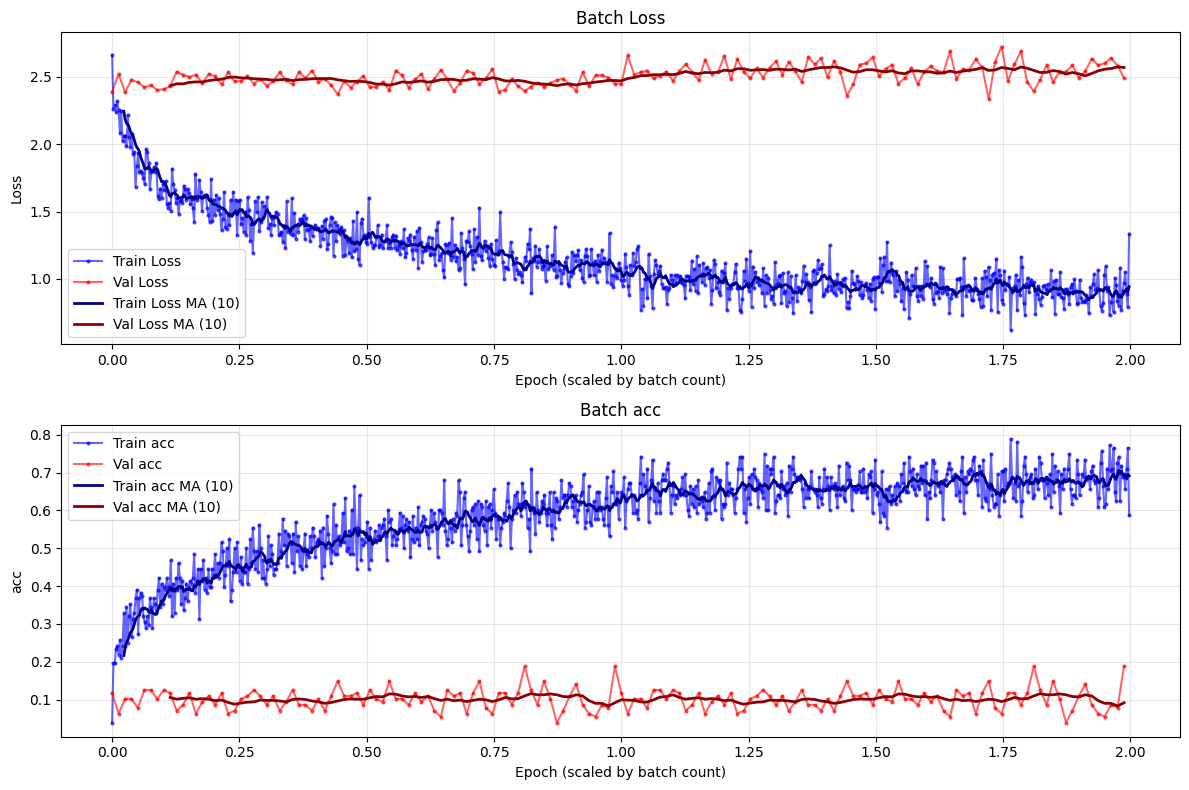

In [32]:
plot_batch_history(batch_hist, metric_name='acc', window=10)

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd
from PIL import Image
import albumentations
from albumentations.pytorch import ToTensorV2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_and_extract_archive

In [3]:
from torch_trainer import *

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [5]:
url_images = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
root_directory = os.path.join(os.getcwd(),'data','pets')

archive_name = url_images.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_images, root_directory)


url_anno   = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

archive_name = url_anno.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_anno, root_directory)

In [6]:
content = os.listdir(root_directory)
print(content)
print('n images = ',len(os.listdir(os.path.join(root_directory, 'images'))))
# print('n anno = ',len(os.listdir(os.path.join(dataset_directory, content[0], "trimaps" ))))

['annotations', 'annotations.tar.gz', 'images', 'images.tar.gz']
n images =  7393


In [7]:
N_TRAIN = 6000
N_TEST  = 100
STEP    = 5

images_directory = os.path.join(root_directory, "images")
masks_directory  = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = os.listdir(images_directory)

images_filenames = [i for i in images_filenames
                        if os.path.splitext(i)[-1]
                            in ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')]

os.path.splitext('/path/to/somefile.ext')

random.shuffle(images_filenames)

train_images_filenames = images_filenames[:N_TRAIN:STEP]
val_images_filenames   = images_filenames[N_TRAIN:-N_TEST:STEP]
test_images_filenames  = images_filenames[-N_TEST::STEP]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1200 258 20


In [8]:
class PetsDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transforms=None):

        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory  = masks_directory

        self.transforms = transforms

    def __len__(self):
        return len(self.images_filenames)

    def preprocess_mask(self, mask):
        mask = np.asarray(mask).astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask

    def __getitem__(self, idx):

        image_filename = self.images_filenames[idx]

        path_ = os.path.join(self.images_directory, image_filename)
        image = np.asarray(Image.open(path_).convert("RGB"))

        path_ = os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png"))
        mask  = Image.open(path_)
        mask  = self.preprocess_mask(mask)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask  = transformed["mask"]

        return image, mask

In [9]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = A.Compose([A.Resize(280, 280),
                             A.RandomCrop(256,256),
                             A.ShiftScaleRotate(0.2,0.2, 30),
                             A.RGBShift(25,25,25),
                             A.RandomBrightnessContrast(0.3,0.3),
                             A.Normalize(mean, std),
                             ToTensorV2(),])

test_transform = A.Compose([A.Resize(256, 256),
                            A.Normalize(mean, std),
                            ToTensorV2()])

train_dataset = PetsDataset(train_images_filenames, images_directory, masks_directory, transforms=train_transform,)

val_dataset   = PetsDataset(val_images_filenames,   images_directory, masks_directory, transforms=test_transform,)

test_dataset  = PetsDataset(test_images_filenames,  images_directory, masks_directory, transforms=test_transform,)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1200
Valid size: 258
Test size: 20


C:\Users\Ronkin\anaconda3\envs\py39\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [18]:
BATCH = 16
train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH,
                shuffle=True)

val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH,
                shuffle=False)

test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH,
                shuffle=False)

In [19]:
import segmentation_models_pytorch as smp
model = smp.FPN(encoder_name="efficientnet-b0", encoder_weights="imagenet", classes=1,)
# summary(model, (1,3,224,224))

In [20]:
def dice_loss(pred, target, smooth=1):
    #flatten label and prediction tensors

    pred    = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    loss = 1 - (2.*intersection + smooth)/(pred.sum() + target.sum() + smooth)

    return loss

# class DiceBCELoss(nn.Module):
#     def __init__(self, weight=1):
#         super().__init__()
#         self.weight = weight

#     def forward(self, pred, target, smooth=1):

#         #comment out if your model contains a sigmoid or equivalent activation layer
#         pred = torch.sigmoid(pred)

#         dice = dice_loss(pred, target, smooth=1)

#         bce = F.binary_cross_entropy(pred.squeeze(), target.squeeze(), reduction='mean')
#         dice_bce = self.weight*bce + dice*(1-self.weight)

#         return dice_bce
class DiceBCELoss(nn.Module):
    def __init__(self, weight=1):
        super().__init__()
        self.weight = weight

    def forward(self, pred, target, smooth=1):
        # Не применяем sigmoid здесь, так как используем binary_cross_entropy_with_logits
        pred_sigmoid = torch.sigmoid(pred)

        dice = dice_loss(pred_sigmoid, target, smooth=1)

        # Используем binary_cross_entropy_with_logits для безопасности при AMP
        bce = F.binary_cross_entropy_with_logits(pred.squeeze(), target.squeeze(), reduction='mean')
        dice_bce = self.weight*bce + dice*(1-self.weight)

        return dice_bce
        

In [21]:
# LR = 0.001
# model = model.to(device)
# criterion = DiceBCELoss(weight = 0.5)
# criterion = criterion.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [22]:
# Используем встроенные функции SMP
class SMPCombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super().__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.0)
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
    
    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        bce = self.bce_loss(pred, target.float())
        return self.dice_weight * dice + self.bce_weight * bce

criterion = SMPCombinedLoss(dice_weight=0.5, bce_weight=0.5)

# Метрики из SMP
def iou_score(pred, target):
    return smp.metrics.functional.iou_score(
        torch.sigmoid(pred), 
        target.float(), 
        threshold=0.5
    ).mean()

def f_score(pred, target):
    return smp.metrics.functional.f_score(
        torch.sigmoid(pred), 
        target.float(), 
        beta=1.0,
        threshold=0.5
    ).mean()

def accuracy_score(pred, target):
    return smp.metrics.functional.accuracy(
        torch.sigmoid(pred), 
        target.float(), 
        threshold=0.5
    ).mean()

# Определим метрики
metrics = {
    'iou': iou_score,
    'f1': f_score,
    'acc': accuracy_score
}



In [23]:
LR = 0.001
model = model.to(device)
# criterion = DiceBCELoss(weight = 0.5)
criterion = SMPCombinedLoss(dice_weight=0.5, bce_weight=0.5)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [36]:


# Запускаем обучение
history_df = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=metrics,
    epochs=2,  # измените на нужное количество эпох
    device=device,
    checkpoint_path="best_segmentation_model.pt",
    monitor_metric="iou",  # или "dice" - метрика для отслеживания
    mode="max",  # максимизируем метрику
    patience=10,
    min_delta=1e-4,
    grad_clip=1.0,
    use_amp=True,  # если GPU поддерживает автоматическое масштабирование
    accumulation_steps=1,
    verbose=True
)

# Построим графики обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['train_iou'], label='Train IoU')
plt.plot(history_df['val_iou'], label='Val IoU')
plt.title('IoU')
plt.legend()

plt.tight_layout()
plt.show()

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 | Time: 241.9s | LR: 1.00e-03 | Train Loss: 0.2994 | Val Loss: 0.1444 | Val iou: 0.3847 ★


Train:   0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
LR = 0.001
model = model.to(device)
# criterion = DiceBCELoss(weight = 0.5)
criterion = SMPCombinedLoss(dice_weight=0.5, bce_weight=0.5)
criterion = criterion.to(device)
# Эффективный batch_size = 128 (без аккумуляции)
# Если хотите эмулировать batch_size=512 → accumulation_steps=4 и lr *= 4
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)  # базовый LR

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# ----------------------------
# 8. Запуск обучения
# ----------------------------

# Запускаем обучение
history_df = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=metrics,
    epochs=2,  # измените на нужное количество эпох
    device=device,
    checkpoint_path="best_segmentation_model.pt",
    monitor_metric="iou",  # или "dice" - метрика для отслеживания
    mode="max",  # максимизируем метрику
    patience=10,
    min_delta=1e-4,
    grad_clip=1.0,
    use_amp=(device.type == 'cuda'),  # если GPU поддерживает автоматическое масштабирование
    accumulation_steps=1,
    verbose=True,
    return_batch_history = True,
)

# history, batch_hist = fit(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     criterion=criterion,
#     metrics=metrics,
#     epochs=2,
#     scheduler=scheduler,
#     patience=7,
#     min_delta=0.001,
#     grad_clip=1.0,
#     use_amp=(device.type == 'cuda'),      # AMP только на GPU
#     ema_decay=0.999,
#     device=device,
#     checkpoint_path='best_model_checkpoint.pt',
#     verbose=True,
#     monitor_metric='f1',                  # early stopping по F1
#     mode='max',
#     accumulation_steps=1,                 # без аккумуляции (можно поставить 2, 4 и т.д.)
#     return_batch_history = True,
# )

print("\n Обучение завершено!")
print(f"Лучшая эпоха: {history.attrs['best_epoch'] + 1}")
print(f"Лучший F1: {history.attrs['best_score']:.4f}")

# Сохранить историю
history.to_csv('training_history.csv', index=False)

Train:   0%|          | 0/75 [00:00<?, ?it/s]

ValueError: Target size (torch.Size([16, 256, 256])) must be the same as input size (torch.Size([16, 1, 256, 256]))

In [2]:
from torch_trainer_v1 import *

[✓] Device: cuda | Seed: 42 | TF32: True


Train:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 01 | Time: 19.8s | LR: 3.00e-04 | Throughput: 2528 samples/s | Train Loss: 1.4298 | Val Loss: 2.3937 | Val f1: 0.0406 ★


Train:   0%|          | 0/391 [00:00<?, ?it/s]

 Async checkpoint saved to best_model.pt


Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 02 | Time: 20.6s | LR: 3.00e-04 | Throughput: 2427 samples/s | Train Loss: 1.0081 | Val Loss: 2.3072 | Val f1: 0.0405 


Train:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 03 | Time: 20.9s | LR: 3.00e-04 | Throughput: 2392 samples/s | Train Loss: 0.8078 | Val Loss: 1.8973 | Val f1: 0.2157 ★
 Async checkpoint saved to best_model.pt


In [34]:
import segmentation_models_pytorch as smp

# Используем встроенные функции SMP
class SMPCombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5):
        super().__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.0)
        self.dice_weight = dice_weight

    def forward(self, pred, target):
        # Убедимся, что target имеет правильную размерность
        if target.dim() == 3:
            target = target.unsqueeze(1)  # Добавляем размерность канала
        target = target.float()
        
        dice = self.dice_loss(pred, target)
        bce = self.bce_loss(pred, target)
        return self.dice_weight * dice +  (1-self.dice_weight) * bce



# Метрики из SMP
def iou_score(pred, target):
    if target.dim() == 3:
        target = target.unsqueeze(1)  # Добавляем размерность канала
    # Преобразуем в бинарные предсказания
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    target = target.float()
    
    intersection = (pred_bin * target).sum((1, 2, 3))
    union = (pred_bin + target - pred_bin * target).sum((1, 2, 3))
    
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def f_score(pred, target):
    if target.dim() == 3:
        target = target.unsqueeze(1)  # Добавляем размерность канала
    # Преобразуем в бинарные предсказания
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    target = target.float()
    
    intersection = (pred_bin * target).sum((1, 2, 3))
    total_pred = pred_bin.sum((1, 2, 3))
    total_target = target.sum((1, 2, 3))
    
    f1 = (2 * intersection + 1e-6) / (total_pred + total_target + 1e-6)
    return f1.mean()

def accuracy_score(pred, target):
    if target.dim() == 3:
        target = target.unsqueeze(1)  # Добавляем размерность канала
    # Преобразуем в бинарные предсказания
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    target = target.float()
    
    correct = (pred_bin == target).float().sum((1, 2, 3))
    total = target.new_tensor(target.shape[1] * target.shape[2] * target.shape[3])
    
    acc = (correct + 1e-6) / (total + 1e-6)
    return acc.mean()

# Определим метрики
metrics = {
    'iou': iou_score,
    'f1': f_score,
    'acc': accuracy_score
}



In [36]:
LR = 0.001
criterion = SMPCombinedLoss(dice_weight=0.5)
criterion.to(device)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)  # базовый LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [37]:
# Запускаем обучение
history_df, batch_history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=metrics,
    epochs=1,
    scheduler = scheduler,
    device=device,
    checkpoint_path="best_segmentation_model.pt",
    monitor_metric="iou",
    mode="max",
    patience=10,
    min_delta=1e-4,
    grad_clip=1.0,
    use_amp=(device.type == 'cuda'),
    accumulation_steps=1,
    verbose=True,
    return_batch_history = True,
)

Train:   0%|          | 0/75 [00:00<?, ?it/s]

Val:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 01 | Time: 22.9s | LR: 1.00e-03 | Train Loss: 0.0927 | Val Loss: 0.0998 | Val iou: 0.8744 ★


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetBlock(nn.Module):
    """Блок U-Net с двумя свертками и активацией"""
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNet(nn.Module):
    """Упрощенная архитектура U-Net"""
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Encoder (downsampling)
        in_ch = in_channels
        for feature in features:
            self.encoder.append(UNetBlock(in_ch, feature))
            in_ch = feature
            
        # Bottleneck
        self.bottleneck = UNetBlock(features[-1], features[-1]*2)
        
        # Decoder (upsampling)
        in_ch = features[-1]*2  # channels after bottleneck
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(in_ch, feature, kernel_size=2, stride=2)
            )
            # После конкатенации: feature*2 (из skip connection + upsampled)
            self.decoder.append(UNetBlock(feature*2, feature))
            in_ch = feature
            
        # Output layer
        self.output = nn.Conv2d(features[0], out_channels, 1)
        
    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for block in self.encoder:
            x = block(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder
        skip_connections = skip_connections[::-1]  # Reverse for decoder
        
        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)  # ConvTranspose2d
            skip = skip_connections[i//2]
            
            # Ensure same spatial dimensions
            if x.shape[2:] != skip.shape[2:]:
                # Interpolate to match spatial dimensions
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
            
            # Concatenate skip connection
            x = torch.cat([x, skip], dim=1)
            x = self.decoder[i+1](x)  # UNetBlock
            
        return self.output(x)

# Пример использования
model = UNet(in_channels=3, out_channels=1)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Проверка размеров
x = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    y = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")

Model parameters: 31,043,521
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class TimmUNet(nn.Module):
    """U-Net с использованием backbone из timm"""
    def __init__(self, 
                 backbone_name='mobilenetv3_small_100',  # легкий backbone
                 in_channels=3, 
                 out_channels=1,
                 pretrained=True):
        super().__init__()
        
        # Загружаем предобученную модель
        self.backbone = timm.create_model(
            backbone_name, 
            features_only=True, 
            pretrained=pretrained,
            out_indices=(0, 1, 2, 3)  # выбираем разные уровни
        )
        
        # Получаем количество каналов для каждого уровня
        self.feature_channels = self.backbone.feature_info.channels()
        
        # Уменьшаем количество каналов для легкости
        self.reduce_convs = nn.ModuleList()
        for ch in self.feature_channels:
            self.reduce_convs.append(
                nn.Conv2d(ch, 32, 1)  # уменьшаем до 32 каналов
            )
        
        # Decoder
        self.decoder_blocks = nn.ModuleList()
        
        # Для каждого уровня decoder создаем upsampling + conv
        for i in range(len(self.feature_channels) - 1):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)  # upsampling
            )
            # После конкатенации: 32 (upsampled) + 32 (skip) = 64
            self.decoder_blocks.append(
                nn.Sequential(
                    nn.Conv2d(64, 32, 3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(32, 32, 3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(inplace=True)
                )
            )
        
        # Дополнительный upsampling до исходного размера
        # Если после decoder все еще меньше чем вход, добавляем еще upsampling
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Final output layer
        self.output = nn.Conv2d(32, out_channels, 1)
        
    def forward(self, x):
        # Получаем признаки из backbone
        features = self.backbone(x)
        
        # Уменьшаем количество каналов
        reduced_features = []
        for feat, conv in zip(features, self.reduce_convs):
            reduced_features.append(conv(feat))
        
        # Начинаем с самого глубокого уровня
        x = reduced_features[-1]
        
        # Decoder с skip connections
        for i in range(0, len(self.decoder_blocks), 2):
            # Upsampling
            x = self.decoder_blocks[i](x)
            
            # Добавляем skip connection
            skip_idx = len(reduced_features) - 2 - (i // 2)
            if skip_idx >= 0:
                skip = reduced_features[skip_idx]
                
                # Убедимся, что размеры совпадают
                if x.shape[2:] != skip.shape[2:]:
                    x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
                
                x = torch.cat([x, skip], dim=1)
            
            # Convolution block
            x = self.decoder_blocks[i+1](x)
        
        # Дополнительный upsampling до размера входа, если нужно
        if x.shape[2:] != features[0].shape[2:]:
            x = self.final_upsample(x)
        
        # Убедимся, что размер совпадает с входом
        if x.shape[2:] != torch.Size([256, 256]):
            x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)
        
        return self.output(x)

# Пример использования
model = TimmUNet(
    backbone_name='mobilenetv3_small_100',  # очень легкий backbone
    in_channels=3, 
    out_channels=1,
    pretrained=True
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Проверка размеров
x = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    y = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")

Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Model parameters: 1,026,401
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])
